# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv
import h5py

In [4]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [5]:
#  ## Code to explore hdf5 data
# def get_ds_dictionaries(name, node):
  
#     fullname = node.name
#     if isinstance(node, h5py.Dataset):
#     # node is a dataset
#         print(f'Dataset: {fullname}; adding to dictionary')
#         ds_dict[fullname] = node[:]
#         print('ds_dict size', len(ds_dict)) 
#     else:
#      # node is a group
#         print(f'Group: {fullname}; skipping')  
    
    
# ds_dict= {}    
# with h5py.File(output_dir+f1) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)

# ds_dict= {}    
# with h5py.File(output_dir+f2) as hf:
#     print(hf.visititems(get_ds_dictionaries))
# print(ds_dict)


In [6]:
## Modules

def f_extract_meson(fname,meson_dict):
    
    with h5py.File(fname) as hf:
#         print(hf.keys())
        meson_dict['corr']=hf['meson']['meson_0']['corr'][:]

    return meson_dict

def f_extract_wi(fname,wi_dict):
    
    with h5py.File(fname) as hf:
#         print(hf.keys())
        for key1,value1 in hf['wardIdentity'].items():
    #         print(key1,value1)
            a1=hf['wardIdentity'][key1]
            wi_dict[key1]=a1[:]

    return wi_dict
    
    
def f_compute_mresidual(meas_dict):
    
#     arr=np.array([i[0]/j[0] for i,j in zip(wi_dict['PJ5q'],meson_dict['corr'])])
    arr=np.array([i[0]/j[0] for i,j in zip(meas_dict['PJ5q'],meas_dict['meson_corr'])])

    return arr

def f_extract_wilson_flow(fname):
    
    keys=['flow_time','Plaq_density','Clover_density','top_charge']
    flow_vars=dict.fromkeys(keys)

    with h5py.File(fname) as hf:
        for idx,key in enumerate(keys):
            print(type(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data']))
            flow_vars[key]=np.array(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data'])
    
    return flow_vars


In [14]:

def f_get_meas(run_dir,epoch):
    
    f1='eta_s_2pt.{0}.h5'.format(epoch)
    f2='prop_gauge_DWF.{0}.h5'.format(epoch)

    meson_dict={}
    meson_dict=f_extract_meson(run_dir+f1,meson_dict)

    wi_dict={}
    wi_dict=f_extract_wi(run_dir+f2,wi_dict)
    
    ## Copy each element of wi_dict into meas_dict
    meas_dict=dict(wi_dict)
    
    meas_dict['meson_corr']=meson_dict['corr']
    
    m_res=f_compute_mresidual(meas_dict)

    meas_dict['m_res']=m_res
    
    return meas_dict
    


def f_plot_mres(meas_dict):
    
    ## Plot correlators
    plt.figure()
    y1=[i[0] for i in meas_dict['PJ5q']]
    plt.plot(y1,linestyle='',marker='*',label='Axial')

    y2=[i[0] for i in meas_dict['meson_corr']]
    plt.plot(y2,linestyle='',marker='o',label='meson')
    plt.yscale('log')
    plt.ylabel('correlator')
    plt.legend()
    
    
    ## Plot residual mass
    plt.figure()
    plt.plot(meas_dict['m_res'],linestyle='',marker='*')
    plt.ylabel("residual mass")
    
    


### Plot mres

In [12]:

run_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_june15_mobius/dm_tests/meas_mobius/run4_/test_1_no_wflow/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/070623_015744-tioga/'


dict_keys(['DmuJmu', 'PA0', 'PJ5q', 'VDmuJmu'])


<IPython.core.display.Javascript object>


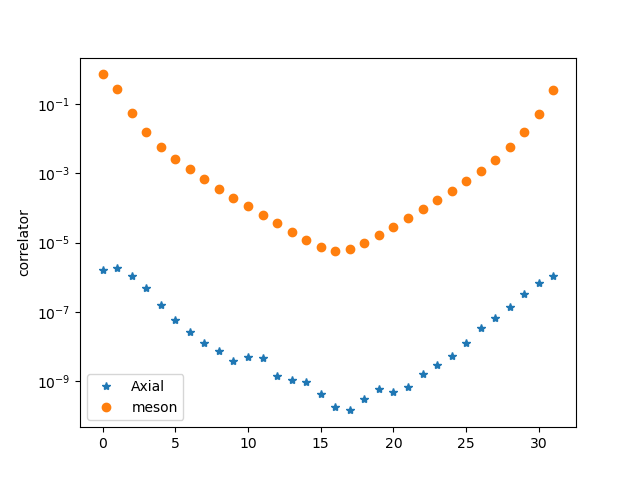

<IPython.core.display.Javascript object>


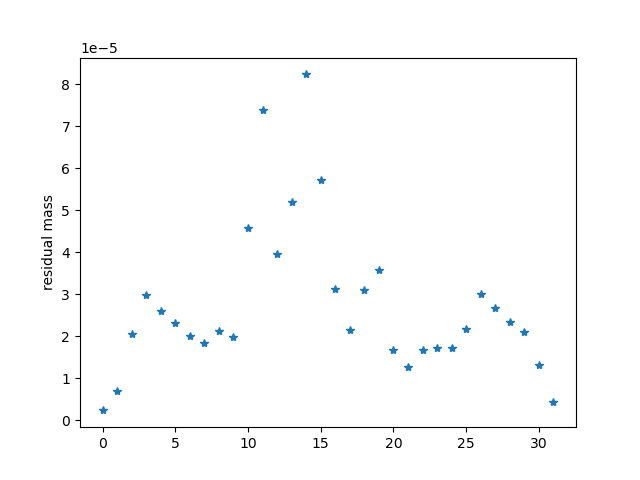

dict_keys(['DmuJmu', 'PA0', 'PJ5q', 'VDmuJmu'])


<IPython.core.display.Javascript object>


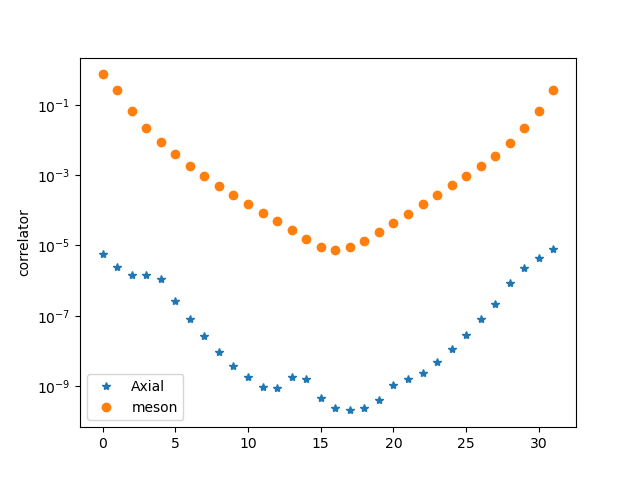

<IPython.core.display.Javascript object>


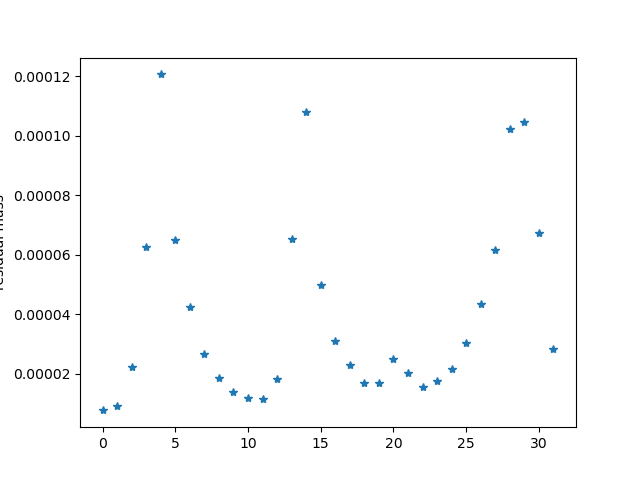

dict_keys(['DmuJmu', 'PA0', 'PJ5q', 'VDmuJmu'])


<IPython.core.display.Javascript object>


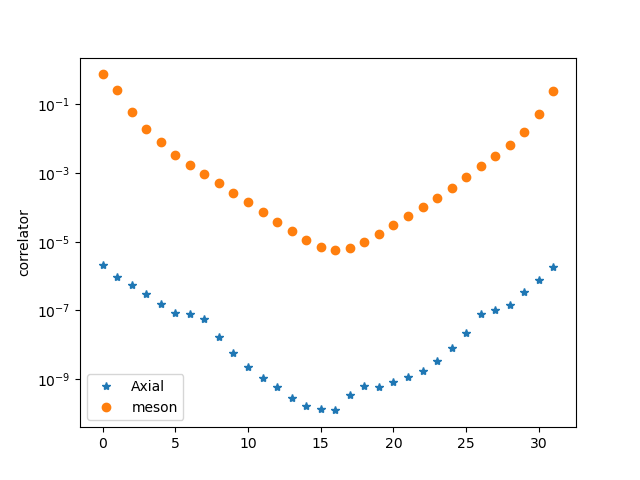

<IPython.core.display.Javascript object>


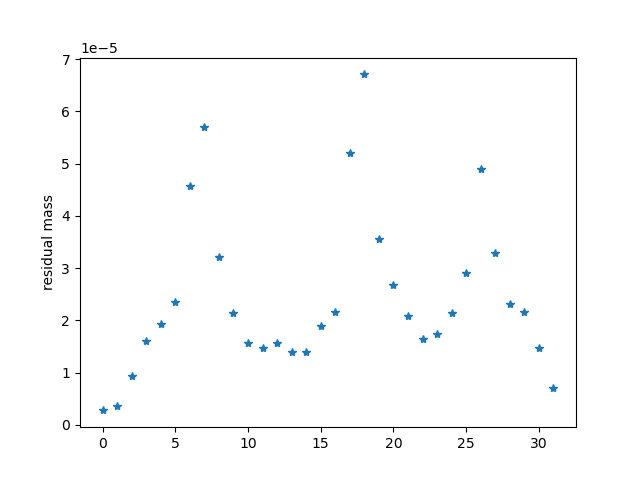

dict_keys(['DmuJmu', 'PA0', 'PJ5q', 'VDmuJmu'])


<IPython.core.display.Javascript object>


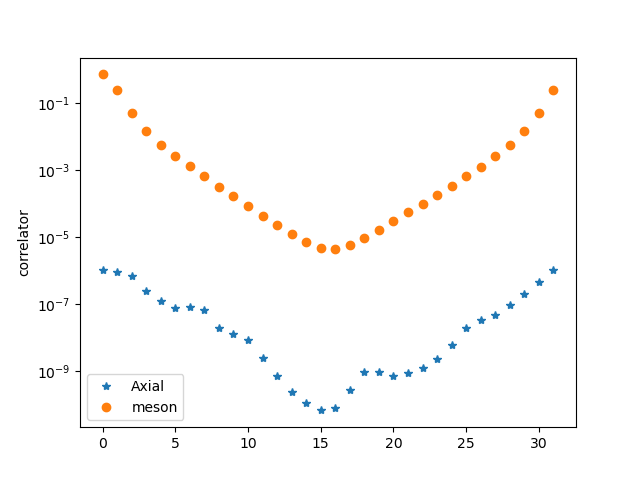

<IPython.core.display.Javascript object>


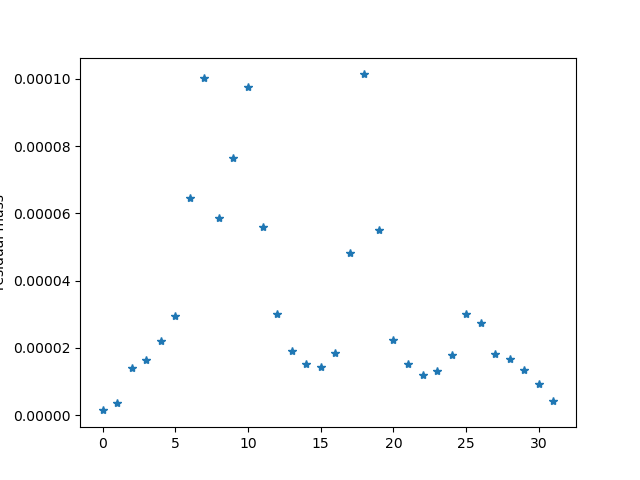

In [13]:

for epoch in [100,110,120,140]:
    
    m1=f_get_meas(run_dir,epoch)
    f_plot_mres(m1)

## Wilson flow

In [10]:
fname='/usr/WS2/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_june15_mobius/dm_tests/meas_mobius/run3_/wilson_flow_test/meas_run_Lx-16_Lt-32_Ls-16_beta-10.8_mf-0.1/063023_035356-tioga_wflow_and_spectrum/Wflow_.100.h5'

In [ ]:
flow_vars=f_extract_wilson_flow(fname)

In [ ]:
# Plot Wilson flow results

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')